In [3]:
%config IPCompleter.greedy=True

In [1]:
#自作モジュール
import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing


In [2]:
"""読み込みと標準化"""

#読み込み
squat1_x_df = pd.read_csv(f'../images/squat1_x_df.csv',index_col=0)
squat1_y_df = pd.read_csv(f'../images/squat1_y_df.csv',index_col=0)
squat2_x_df = pd.read_csv(f'../images/squat2_x_df.csv',index_col=0)
squat2_y_df = pd.read_csv(f'../images/squat2_y_df.csv',index_col=0)


#標準化（関数）
def standarizatioin_df(df):
    """
    身長を1として標準化する
    身長は鼻と(右)くるぶしまでの距離が一番大きかったものとする

    Args:
        df (pd.DataFrame): データフレーム

    Returns:
        (pd.DataFrame): データフレーム
    """
    #身長: 鼻と(右)くるぶしまでの距離が一番大きかったものを身長とする
    height_series = df.iloc[:,16]-df.iloc[:,0]
    height = height_series.max()


    for rep in range(1,15):
        df.iloc[:,rep] = (df.iloc[:,16] - df.iloc[:,rep]) / height
    return df


#標準化
squat1_x_df = standarizatioin_df(squat1_x_df)
squat1_y_df = standarizatioin_df(squat1_y_df)
squat2_x_df = standarizatioin_df(squat2_x_df)
squat2_y_df = standarizatioin_df(squat2_y_df)


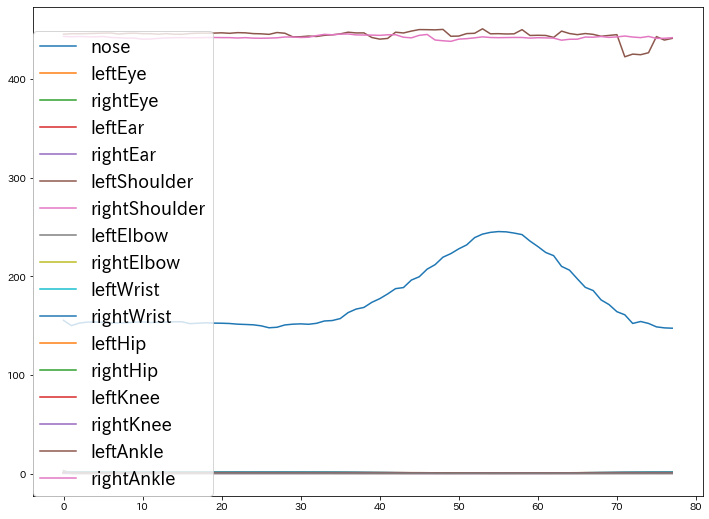

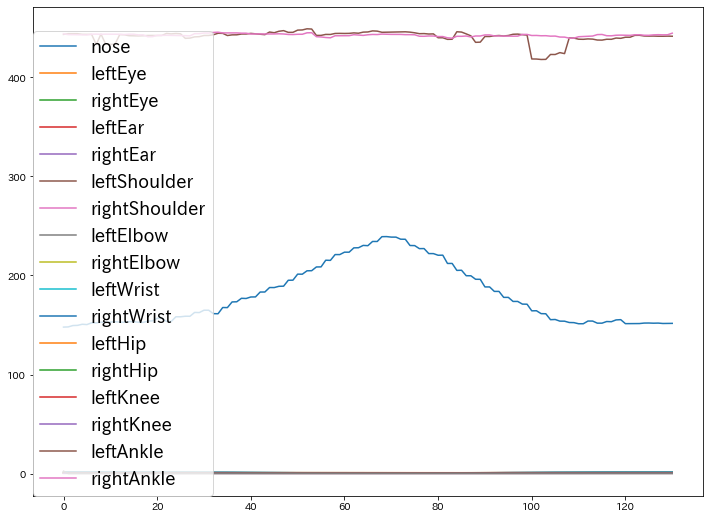

In [3]:

#該当のdfをグラフ化
modules.draw_graph(squat1_y_df)
modules.draw_graph(squat2_y_df)

In [7]:
"""
'leftHip','rightHip'に関して
1. 実際にスクワットをしている部分を切り抜く
2. 同プロット数でないとコサイン類似度が使えないのでプロット点を水増し
3. 周波数領域に変換（実験的に）
4. プロット点の数が一致しない(なんで？？)ので、とりあえず数を合わせてみてコサイン類似度を計算
"""
def calculate_cosine_of_hip(squat1_x_df,squat1_y_df,squat2_x_df,squat2_y_df):
    #1
    crop_squat2_y_df = modules.crop_filter(squat2_y_df)
    crop_squat1_y_df = modules.crop_filter(squat1_y_df)

    #2
    plot_squat2_y_df,plot_squat1_y_df = modules.more_plotpoints(crop_squat2_y_df,crop_squat1_y_df)

    #3
    high_squat2_y_df = modules.high_pass_filter(plot_squat2_y_df)
    high_squat1_y_df = modules.high_pass_filter(plot_squat1_y_df)

    #4
    lendim  = min(plot_squat2_y_df.shape[0],plot_squat1_y_df.shape[0])
    #leftHip
    right_value = modules.cos_sim(plot_squat2_y_df.iloc[:lendim,0],plot_squat1_y_df.iloc[:lendim,0])
    left_value = modules.cos_sim(plot_squat2_y_df.iloc[:lendim,1],plot_squat1_y_df.iloc[:lendim,1])
    print("コサイン類似度は"+(right_value + left_value)/2)


In [29]:
"""
・項目
安定度(横へのブレ)
深さ(しっかりしゃがんでいるか)
負荷率(しゃがみ時のキツイ体勢を何秒維持出来ているか)

(秒数はタイミング合わせるの難しかったりリズム感無いと厳しいので保留)


・安定度
→横ブレの検知(比較先の動画のみにおいて、体幹に関するジャッジ)

・深さ
→角度を無視した場合(角度がつくとどれだけ深いか判定しにくい)。くるぶし:ひざ:腰の比率

・負荷率(しゃがみ時のキツイ体勢を何秒維持出来ているか?)
"""



def horizontal_stability(df):
    """
    安定度
    -> 横ブレの検知(比較先の動画のみにおいて、体幹に関するジャッジ)

    比較元の安定度の1.0倍以下なら「とても良い」1.5倍以下なら「少しブレる」1.5倍以上なら「安定性が無い」
    """

    #ブレ (0~6,11~12: 頭、目、耳、肩、腰)
    nine_stability = 0
    for rep in [0,1,2,3,4,5,6,11,12]:
        nine_stability += ( df.iloc[:,rep].map(lambda x: np.power(x - df.iloc[:,0].mean(),2)).sum() / df.shape[0])
    return nine_stability/9  

def down_depth(df):
    """
    ・深さ
    -> 身長に対してどれだけ沈んだか
    """
    #身長: 鼻と(右)くるぶしまでの距離が一番大きかったものを身長とする
    height_series = df.iloc[:,16]-df.iloc[:,0]
    height = height_series.max()
    print(height)

    #深さ: 腰の高さの最大値と最小値の差
    print(df.iloc[:,11])
    hip_depth = df.iloc[:,11].max() - df.iloc[:,11].min()
    print(hip_depth)

    print(hip_depth/height)


horizontal_stability(squat1_x_df)
horizontal_stability(squat2_x_df)
down_depth(squat1_y_df)


294.77175596162886
0    -0.729191
1    -0.860296
2    -0.933404
3    -0.946099
4    -0.947729
        ...   
73   -0.720263
74   -0.428955
75   -0.528188
76   -0.832281
77   -0.631916
Name: leftHip, Length: 78, dtype: float64
3.128667887347558
0.010613865894786828
